In [11]:
# Check GPU availability
import torch
import os

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✓ GPU Available: {gpu_info}")
    print(f"  Memory: {gpu_memory:.1f} GB")
else:
    print("❌ No GPU detected!")
    print("Go to Runtime → Change runtime type → GPU")

✓ GPU Available: Tesla T4
  Memory: 15.8 GB



# SAE Comparison Experiment - Google Colab
### This notebook runs your SAE comparison experiment with the existing code.

### 1. Setup Environment

In [12]:
# %%
# Check GPU
!nvidia-smi

# %%
# Clone your repository (replace with your actual repo URL)
!git clone https://github.com/StrikerAI-Innovation/mechanistic-interpretability-scale.git repo
%cd repo

# %%
# Install required packages
!pip install torch transformers datasets accelerate -q
!pip install numpy pandas matplotlib seaborn tqdm pyyaml -q
!pip install einops wandb -q

Fri Aug  1 18:02:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2. Import and Test

In [13]:
# %%
import sys
import os
sys.path.append(os.getcwd())

# Test imports
try:
    from src.models.base_sae import BaseSAE
    from src.models.k_sparse_sae import KSparseSAE
    from src.models.hybrid_sae import HybridSAE
    from src.models.vanilla_sae import VanillaSAE
    from src.training.trainer import SAETrainer
    from src.utils.data_loading import create_dataloader
    from src.utils.model_loading import load_model
    print("✓ All imports successful!")
except Exception as e:
    print(f"❌ Import error: {e}")

# %%
# Check PyTorch and GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✓ All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


### 3. Create Simplified Config

**bold text**# %%
# Create a Colab-friendly config
import yaml

colab_config = {
    'seed': 42,
    'dataset': 'wikitext',
    'max_train_samples': 5000,   # Reduced for Colab
    'max_val_samples': 1000,     # Reduced for Colab
    'k_sparse': 64,              # Reduced from 128
    'training': {
        'batch_size': 16,        # Reduced from 32
        'epochs': 5,             # Reduced from 10
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'warmup_steps': 500,
        'max_grad_norm': 1.0,
        'scheduler_type': 'cosine'
    }
}

# Save config
os.makedirs('experiments/01_sae_comparison', exist_ok=True)
with open('experiments/01_sae_comparison/colab_config.yaml', 'w') as f:
    yaml.dump(colab_config, f)

print("Config created!")


In [14]:
# Cell 1: Check current directory
!pwd
!ls -la

# Cell 2: Create config in the RIGHT location
import yaml
import os

# Make sure we're in the repo directory
%cd /content/repo

# Create config
colab_config = {
    'seed': 42,
    'dataset': 'wikitext',
    'max_train_samples': 5000,
    'max_val_samples': 1000,
    'k_sparse': 64,
    'training': {
        'batch_size': 16,
        'epochs': 5,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'warmup_steps': 500,
        'max_grad_norm': 1.0,
        'scheduler_type': 'cosine'
    }
}

# Save config (without 'repo' in path since we're already in repo)
os.makedirs('experiments/01_sae_comparison', exist_ok=True)
with open('experiments/01_sae_comparison/colab_config.yaml', 'w') as f:
    yaml.dump(colab_config, f)

# Verify it exists
!ls -la experiments/01_sae_comparison/
print("Config created at:", os.path.abspath('experiments/01_sae_comparison/colab_config.yaml'))

/content/repo/repo
total 76
drwxr-xr-x  6 root root  4096 Aug  1 18:02 .
drwxr-xr-x 10 root root  4096 Aug  1 18:02 ..
-rw-r--r--  1 root root  3001 Aug  1 18:02 colab-simple-runner.py
-rw-r--r--  1 root root  8865 Aug  1 18:02 complete-colab-notebook.ipynb
drwxr-xr-x  3 root root  4096 Aug  1 18:02 experiments
drwxr-xr-x  8 root root  4096 Aug  1 18:02 .git
-rw-r--r--  1 root root  1079 Aug  1 18:02 .gitignore
-rw-r--r--  1 root root  6134 Aug  1 18:02 README.md
-rw-r--r--  1 root root   721 Aug  1 18:02 requirements.txt
-rw-r--r--  1 root root 14945 Aug  1 18:02 run_sae_comparison_colab.ipynb
drwxr-xr-x  2 root root  4096 Aug  1 18:02 scripts
-rw-r--r--  1 root root  2098 Aug  1 18:02 setup.py
drwxr-xr-x  6 root root  4096 Aug  1 18:02 src
/content/repo
total 40
drwxr-xr-x 2 root root  4096 Aug  1 17:21 .
drwxr-xr-x 3 root root  4096 Aug  1 17:18 ..
-rw-r--r-- 1 root root   237 Aug  1 18:02 colab_config.yaml
-rw-r--r-- 1 root root  1957 Aug  1 17:18 config.yaml
-rw-r--r-- 1 root root

### 4. Run Quick Test

In [15]:
# Complete fix for import issues
import sys
import os

# 1. Make sure we're in the repo directory
%cd /content/repo

# 2. Add to Python path
sys.path.insert(0, os.getcwd())

# 3. Create all __init__.py files
!touch src/__init__.py
!touch src/models/__init__.py
!touch src/training/__init__.py
!touch src/utils/__init__.py

# 4. Create proper models __init__.py
models_init = """from .base_sae import BaseSAE
from .k_sparse_sae import KSparseSAE
from .hybrid_sae import HybridSAE
from .vanilla_sae import VanillaSAE

__all__ = ['BaseSAE', 'KSparseSAE', 'HybridSAE', 'VanillaSAE']
"""

with open('src/models/__init__.py', 'w') as f:
    f.write(models_init)

# 5. Create minimal setup.py
setup_py = """from setuptools import setup, find_packages

setup(
    name="mechanistic-interpretability",
    version="0.1.0",
    packages=find_packages(),
)
"""

with open('setup.py', 'w') as f:
    f.write(setup_py)

# 6. Install package
!pip install -e . -q

# 7. Test imports
try:
    from src.models import KSparseSAE , HybridSAE, VanillaSAE
    print("✓ Import successful!")
except Exception as e:
    print(f"❌ Still getting error: {e}")

# 8. Debug information
print("\nDebug info:")
print(f"Current directory: {os.getcwd()}")
print(f"Files in src/models/:")
!ls -la src/models/

/content/repo
  Preparing metadata (setup.py) ... done
❌ Still getting error: cannot import name 'KSparseSAE' from 'src.models' (unknown location)

Debug info:
Current directory: /content/repo
Files in src/models/:
total 64
drwxr-xr-x 3 root root  4096 Aug  1 17:21 .
drwxr-xr-x 7 root root  4096 Aug  1 17:22 ..
-rw-r--r-- 1 root root 13553 Aug  1 17:18 base_sae.py
-rw-r--r-- 1 root root 13574 Aug  1 17:18 hybrid_sae.py
-rw-r--r-- 1 root root   201 Aug  1 18:02 __init__.py
-rw-r--r-- 1 root root  8619 Aug  1 17:18 k_sparse_sae.py
drwxr-xr-x 2 root root  4096 Aug  1 17:22 __pycache__
-rw-r--r-- 1 root root  3784 Aug  1 17:18 vanilla_sae.py


In [16]:
# Complete setup and run
import os
import sys
import yaml

# 1. Ensure we're in the right directory
%cd /content/repo
print(f"Current directory: {os.getcwd()}")

# 2. Create config
colab_config = {
    'seed': 42,
    'dataset': 'wikitext',
    'max_train_samples': 5000,
    'max_val_samples': 1000,
    'k_sparse': 64,
    'training': {
        'batch_size': 16,
        'epochs': 5,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'warmup_steps': 500,
        'max_grad_norm': 1.0,
        'scheduler_type': 'cosine'
    }
}

# 3. Save config in the correct location
config_dir = 'experiments/01_sae_comparison'
os.makedirs(config_dir, exist_ok=True)
config_path = os.path.join(config_dir, 'colab_config.yaml')

with open(config_path, 'w') as f:
    yaml.dump(colab_config, f)

print(f"Config saved to: {config_path}")
print(f"Config exists: {os.path.exists(config_path)}")

# 4. Set Python path
sys.path.insert(0, os.getcwd())

# 5. Run experiment with correct config path
!PYTHONPATH=/content/repo python experiments/01_sae_comparison/run_comparison.py \
    --model gpt2 \
    --layer 6 \
    --n_features 4096 \
    --batch_size 8 \
    --epochs 2 \
    --debug \
    --config experiments/01_sae_comparison/colab_config.yaml

/content/repo
Current directory: /content/repo
Config saved to: experiments/01_sae_comparison/colab_config.yaml
Config exists: True
2025-08-01 18:03:29.218767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754071409.290385   13152 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754071409.314642   13152 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754071409.368458   13152 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754071409.368516   13152 computation_placer.cc:177] computation placer already registered. Please check linkage and a

In [17]:
# Run this in a cell to debug the model structure
from transformers import AutoModel
from src.utils.data_loading import get_layer_by_name

# Load the model
model = AutoModel.from_pretrained("gpt2")

print("="*50)
print("DEBUGGING GPT-2 MODEL STRUCTURE")
print("="*50)

# Print the model structure
print("\nModel children:")
for name, module in model.named_children():
    print(f"  {name}: {type(module).__name__}")

# Check if transformer exists
if hasattr(model, 'transformer'):
    print(f"\nTransformer children:")
    for name, module in model.transformer.named_children():
        print(f"  transformer.{name}: {type(module).__name__}")

    # Check the h attribute (transformer blocks)
    if hasattr(model, 'h'):
        print(f"\nFound {len(model.h)} transformer blocks:")
        for i in range(min(3, len(model.h))):  # Show first 3
            print(f"  transformer.h.{i}: {type(model.h[i]).__name__}")

# Test accessing layer 6
test_layer = get_layer_by_name(model, "h.6")
if test_layer:
    print(f"\n✓ Successfully accessed transformer.h.6: {type(test_layer).__name__}")
else:
    print(f"\n✗ Could not access transformer.h.6")

    # Try alternative access methods
    try:
        direct_access = model.transformer.h[6]
        print(f"✓ Direct access works: model.transformer.h[6] = {type(direct_access).__name__}")
    except Exception as e:
        print(f"✗ Direct access failed: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

DEBUGGING GPT-2 MODEL STRUCTURE

Model children:
  wte: Embedding
  wpe: Embedding
  drop: Dropout
  h: ModuleList
  ln_f: LayerNorm
Trying to access layer: h.6
Parts: ['h', '6']
  Step 0: Looking for 'h' in GPT2Model
    ✓ Found: ModuleList
  Step 1: Looking for '6' in ModuleList
    ✓ Found: GPT2Block
Successfully found layer: GPT2Block

✓ Successfully accessed transformer.h.6: GPT2Block


## 5. Run Main Experiment

In [18]:
# %%
# Run the full comparison (this will take 1-3 hours)
!python experiments/01_sae_comparison/run_comparison.py \
    --model gpt2 \
    --layer 6 \
    --n_features 8192 \
    --batch_size 16 \
    --epochs 5 \
    --config experiments/01_sae_comparison/colab_config.yaml

2025-08-01 18:04:26.735151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754071466.764602   13717 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754071466.773080   13717 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754071466.788999   13717 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754071466.789040   13717 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754071466.789044   13717 computation_placer.cc:177] computation placer alr

### 6. Visualize Results

Results directory: results/sae_comparison_gpt2_layer6_20250801_180430

Summary Results:


,Model,Reconstruction Error,Sparsity Level,Active Features,Dead Features (%),Inference Time (ms),Memory (MB)
0,K-Sparse,37.9199 ± 136.3147,21.9 ± 5.0,40,97.0%,1.17,1175.0
1,Hybrid (Ours),4.4402 ± 60.1158,46.5 ± 19.2,160,94.9%,6.42,1891.2
2,Vanilla,37.9598 ± 143.8191,238.3 ± 218.6,965,57.3%,0.86,1938.7



efficiency_tradeoff.png:


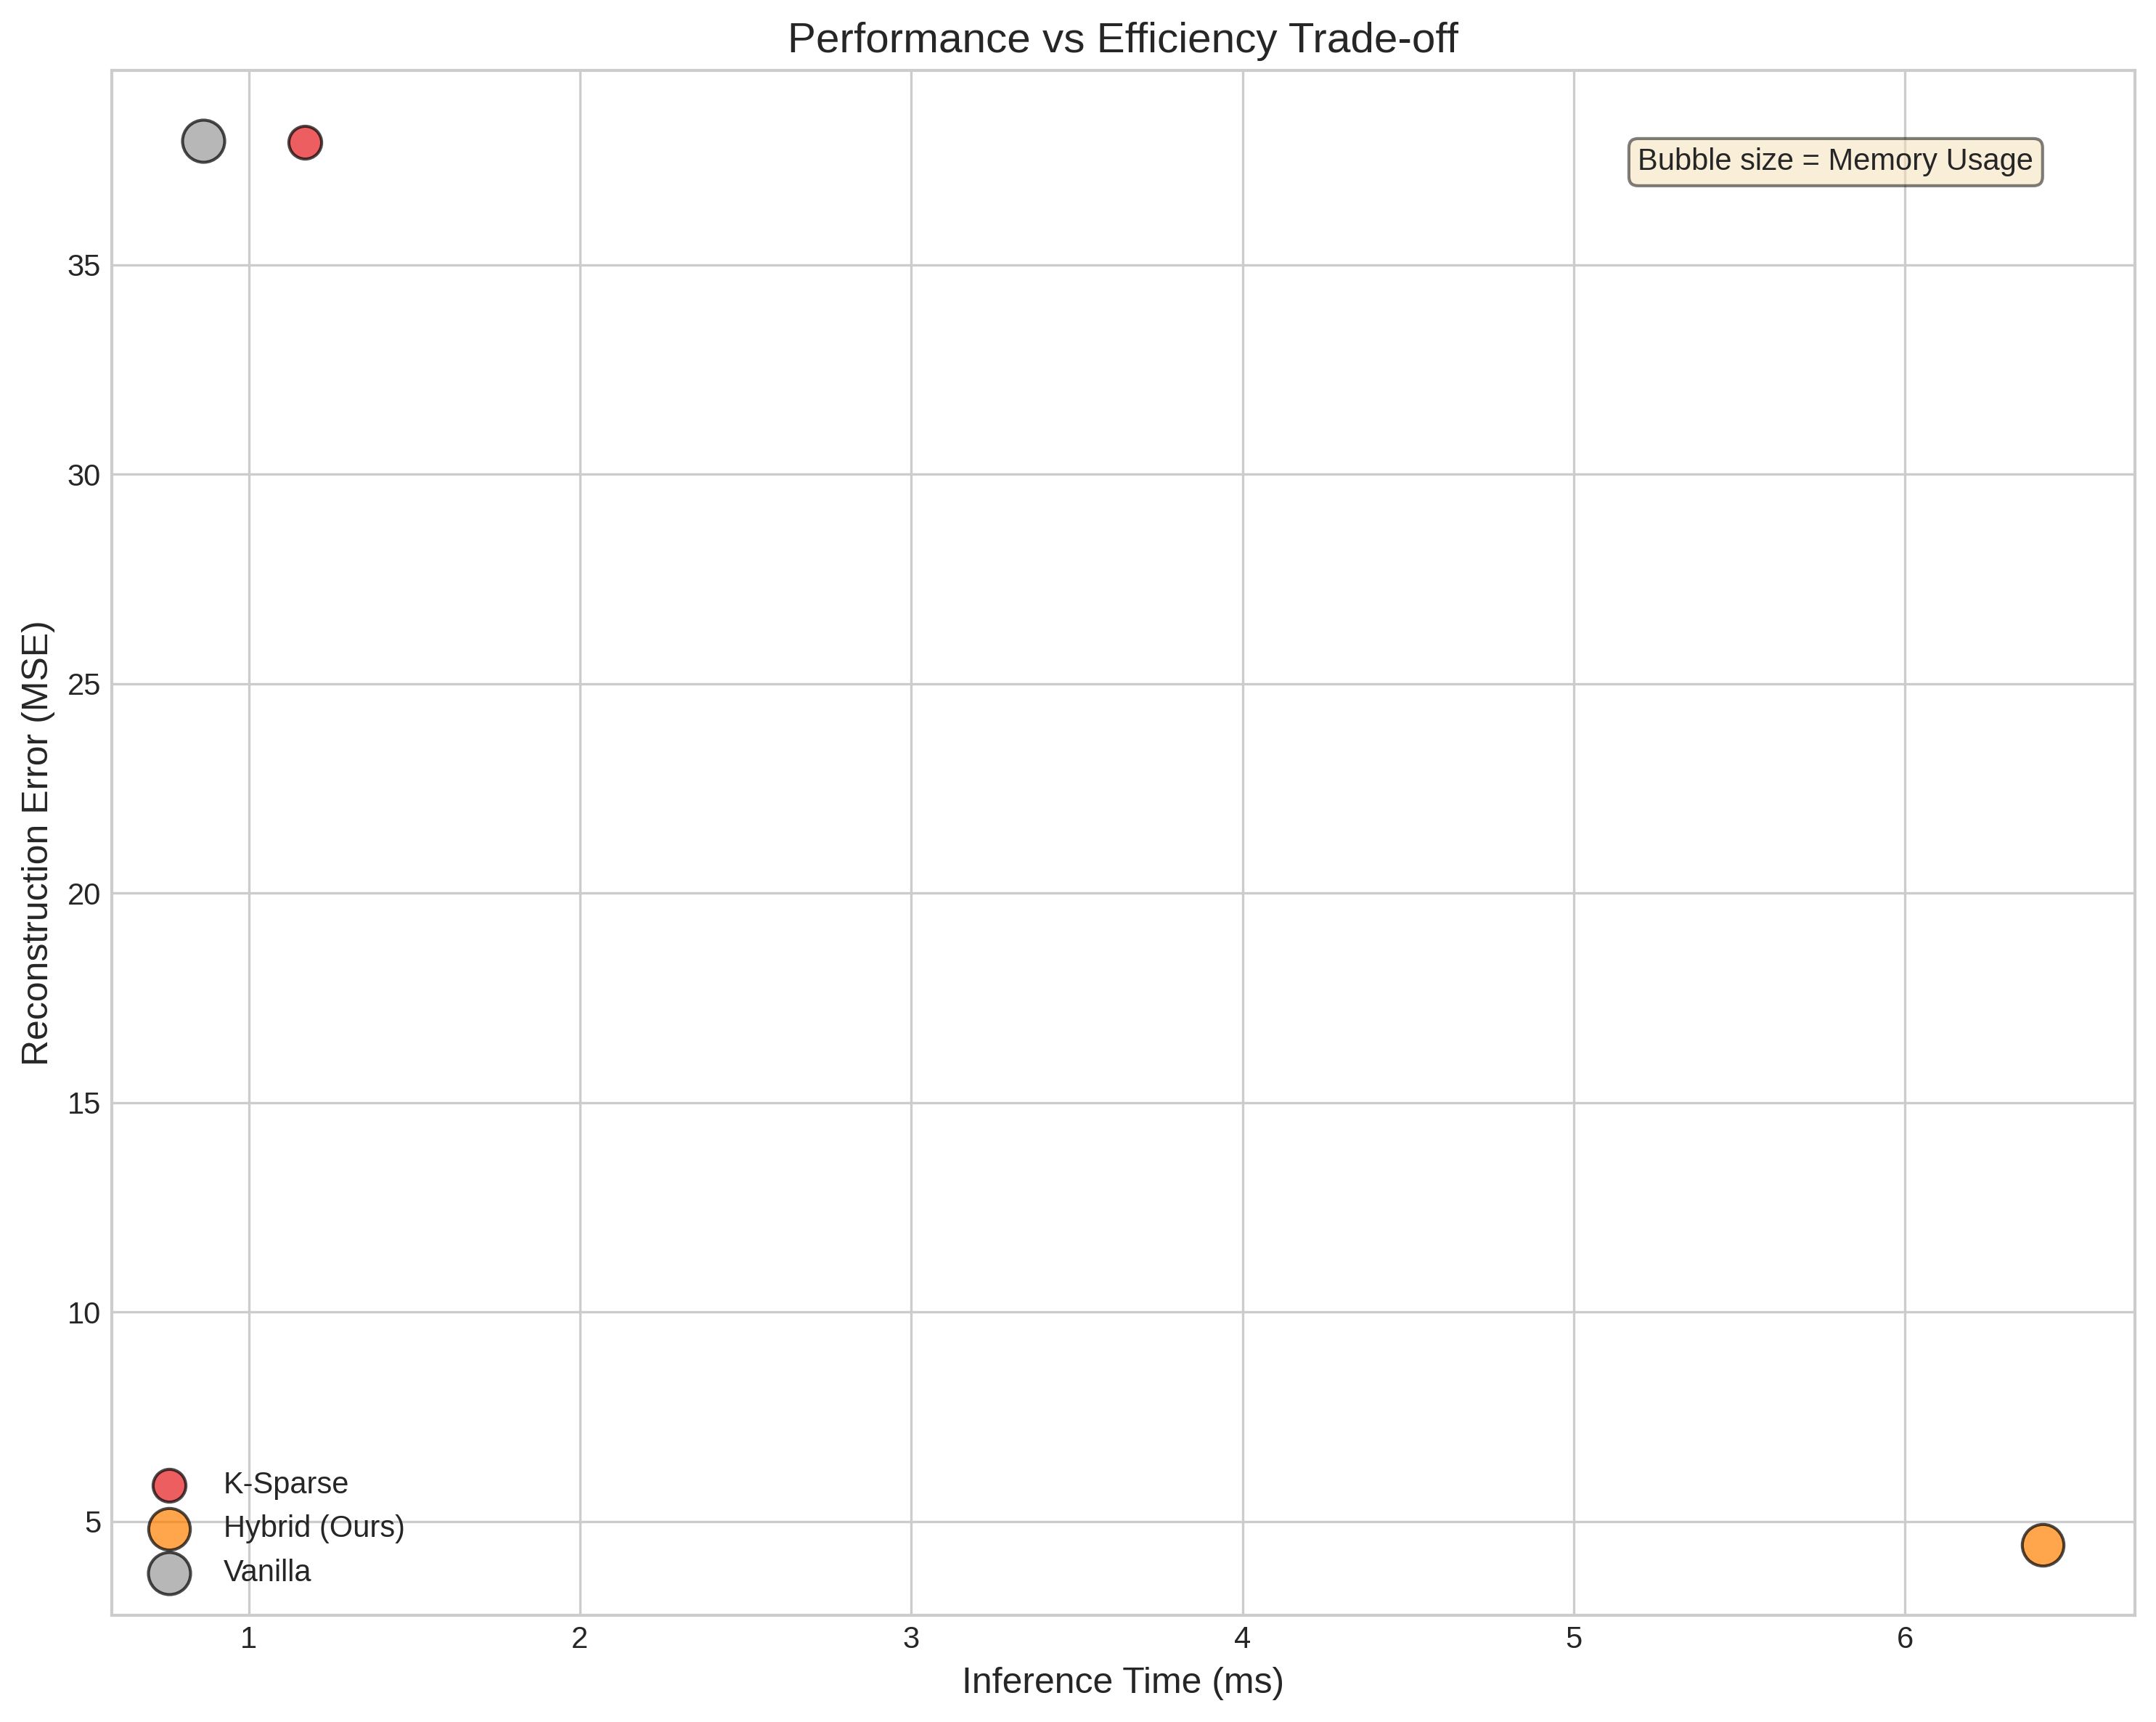


performance_comparison.png:


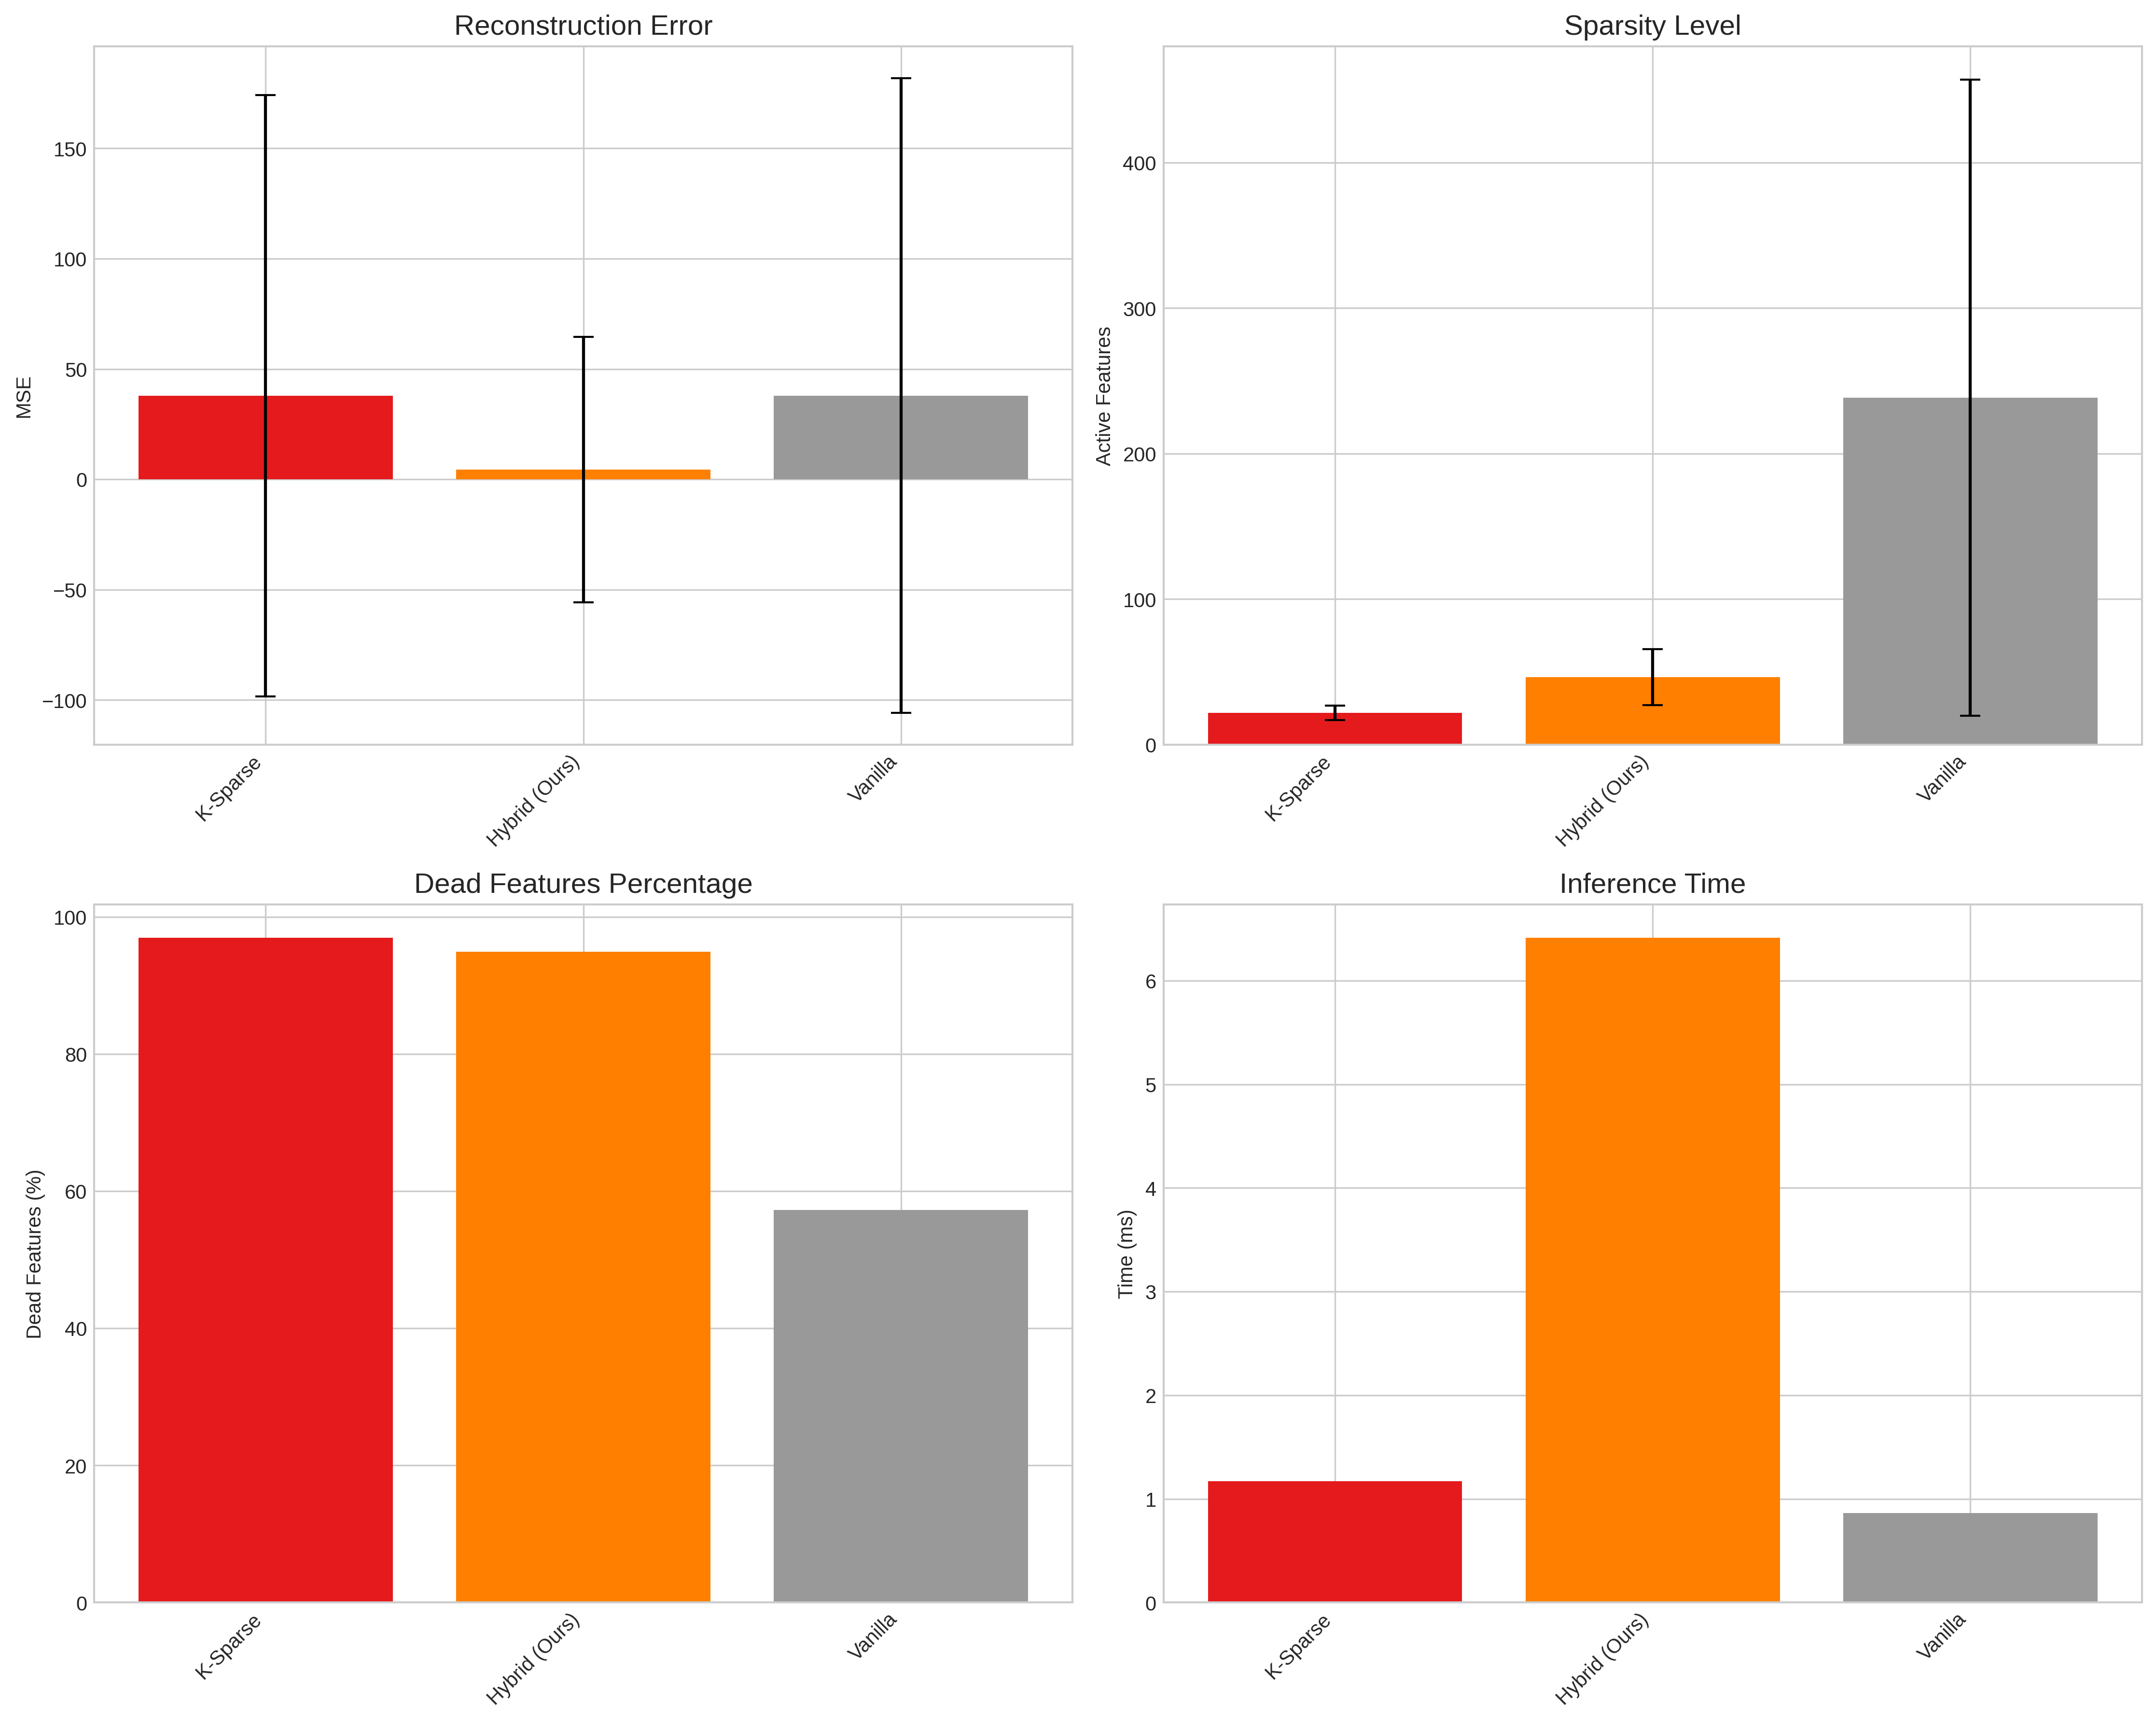


hybrid_feature_activation.png:


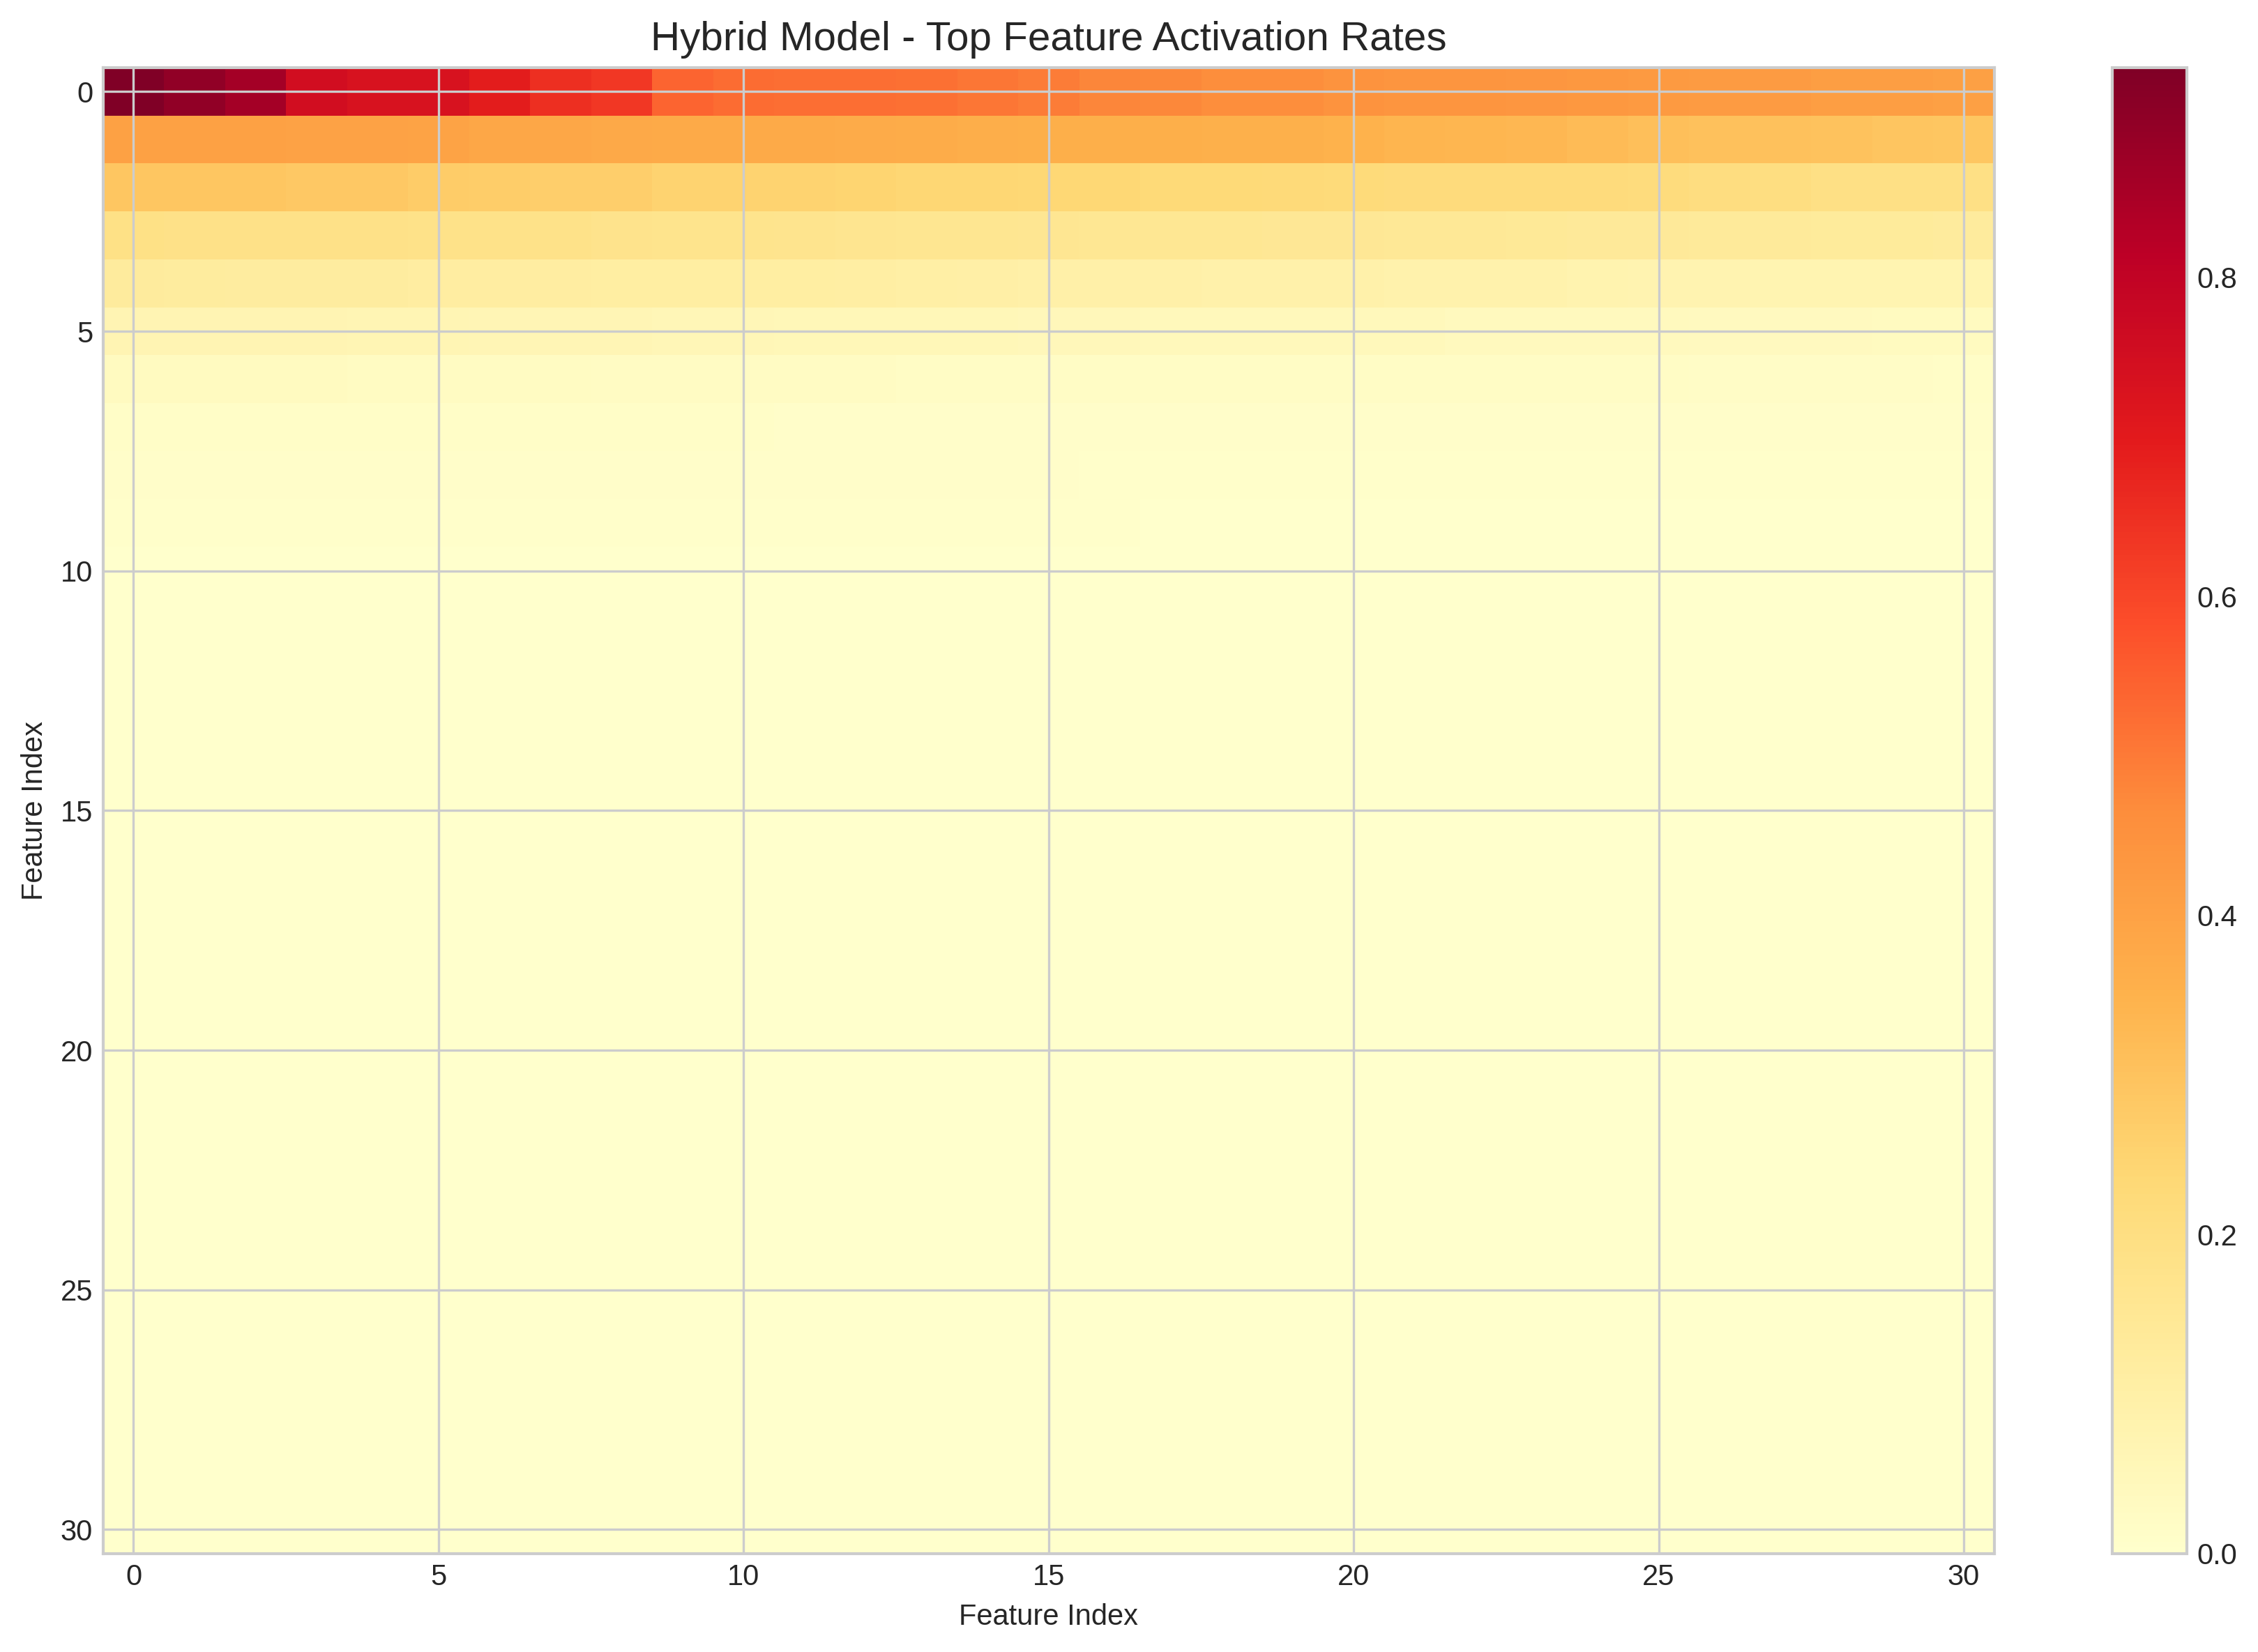


training_curves.png:


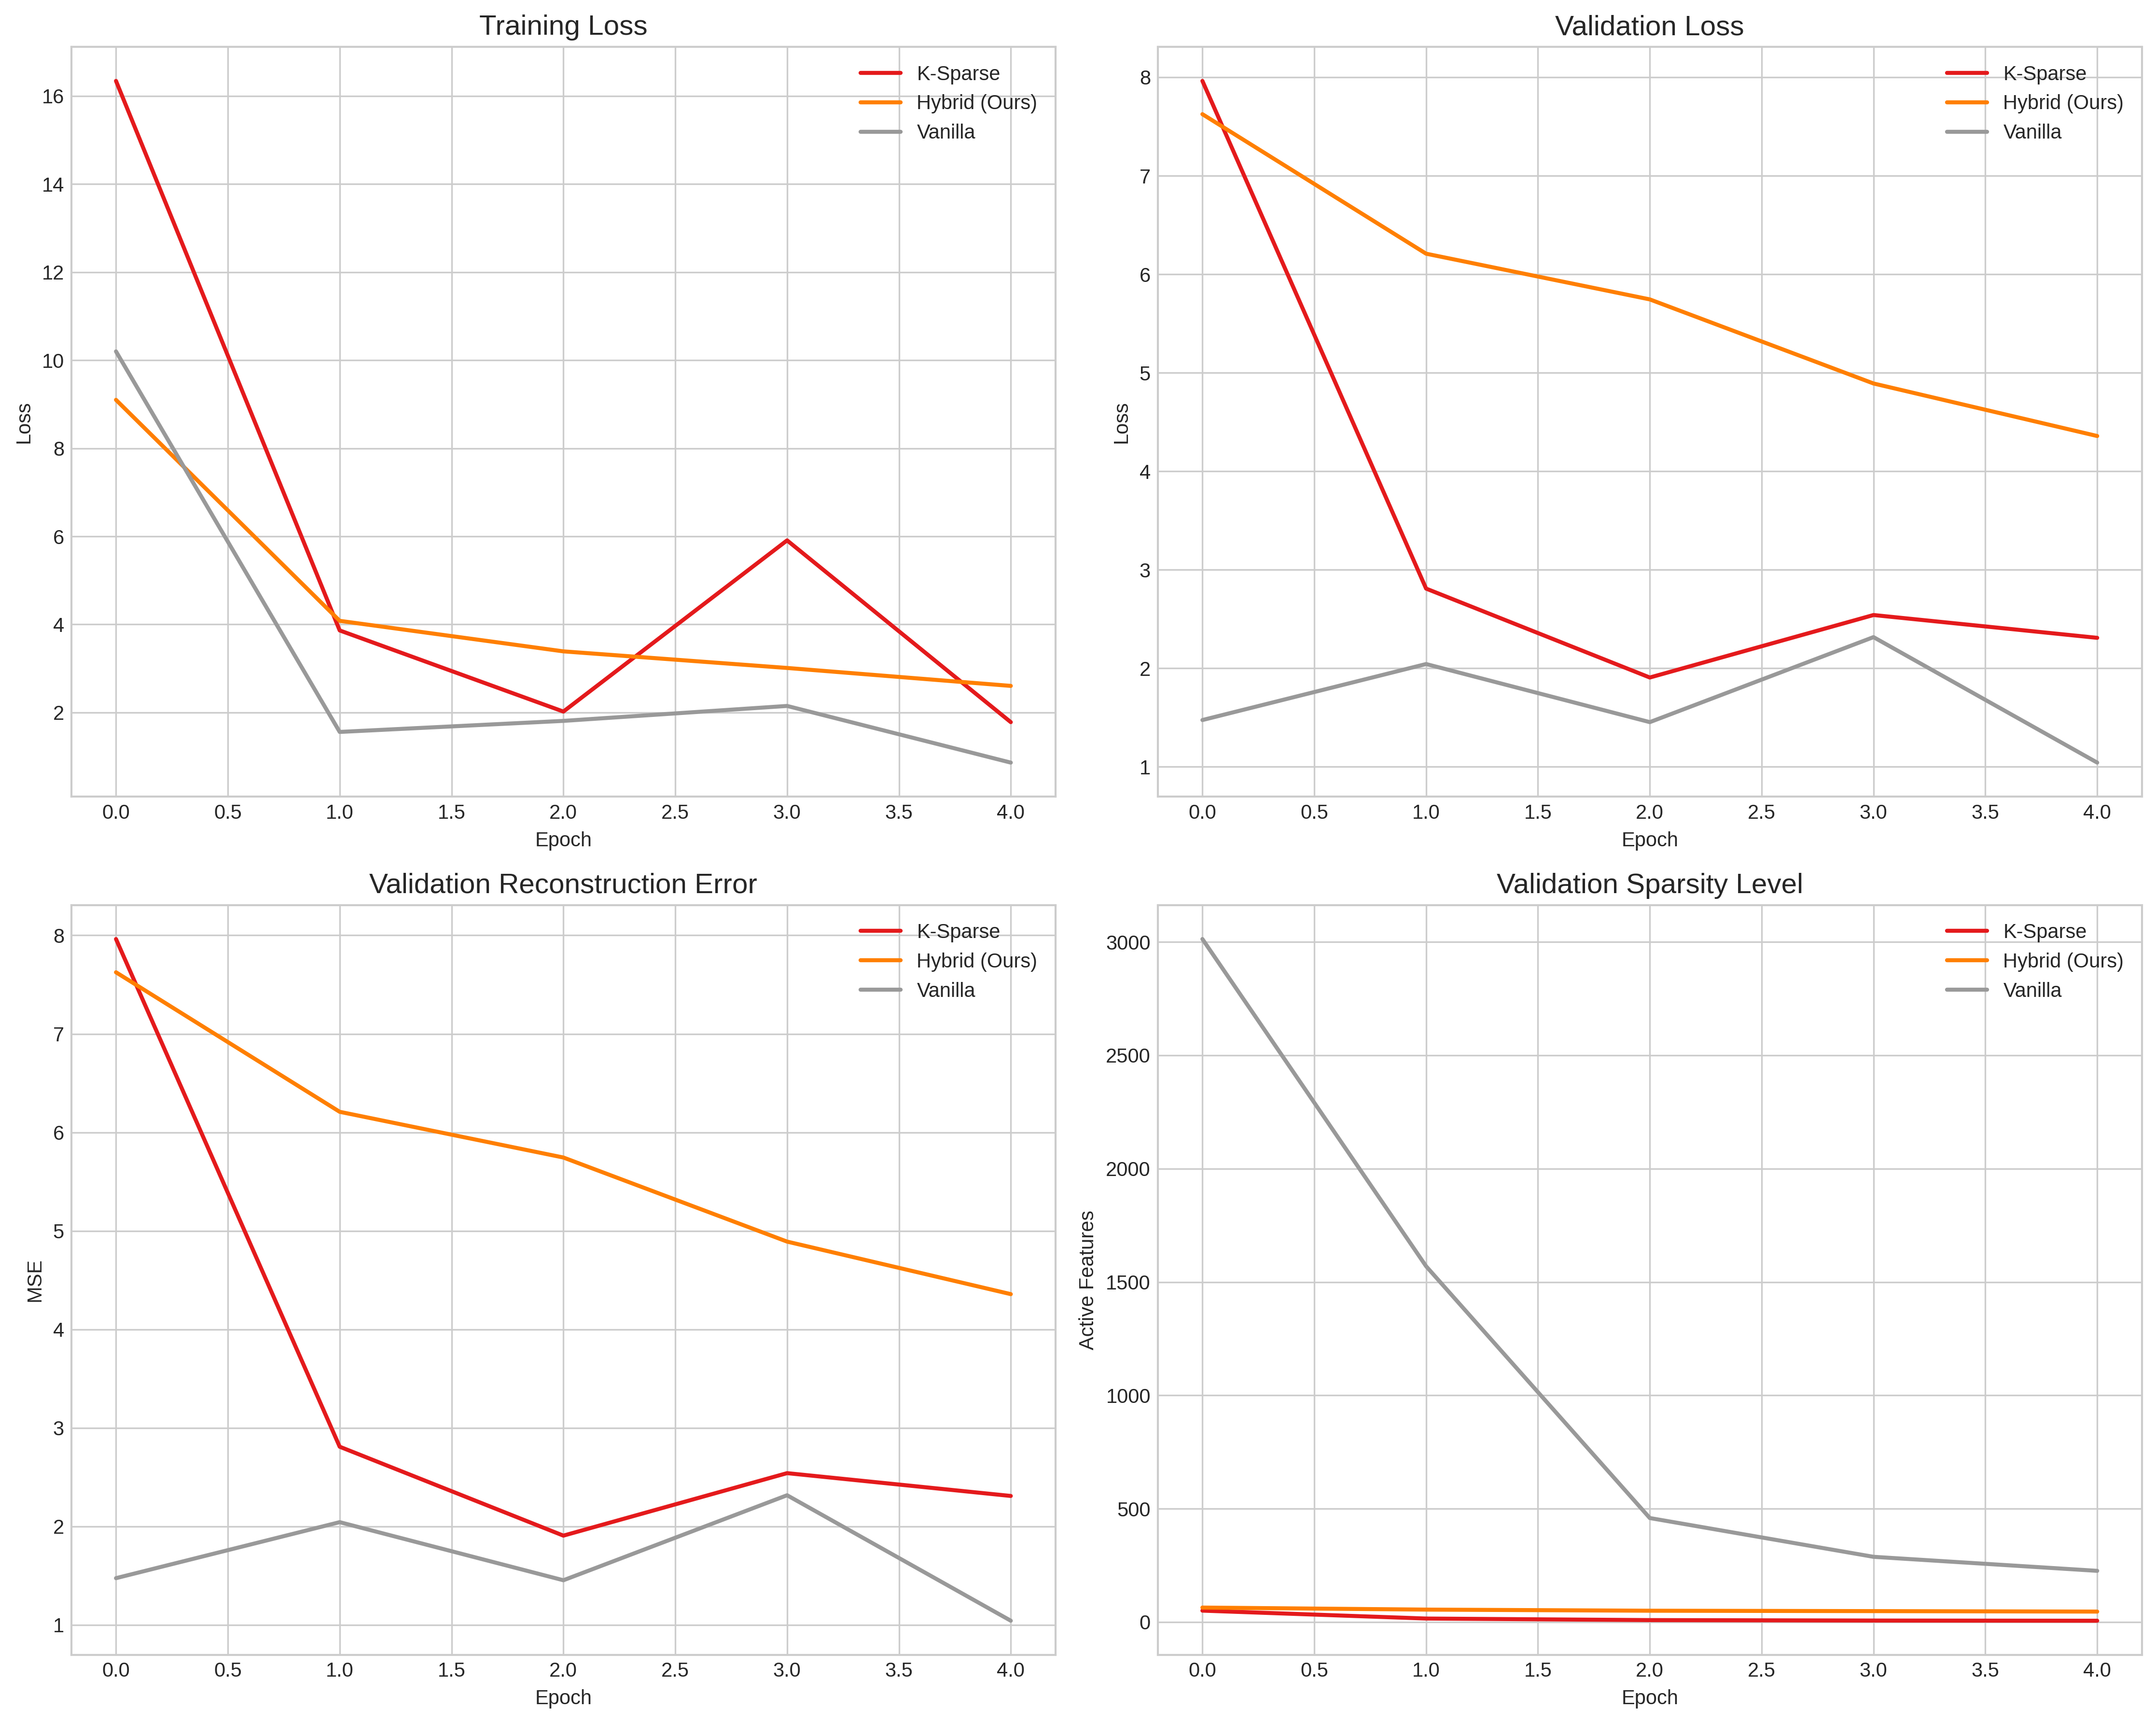

In [19]:
# %%
# Load and display results
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Image, display

# Find the latest results directory
results_dirs = sorted(Path('results').glob('sae_comparison_*'))
if results_dirs:
    latest_results = results_dirs[-1]
    print(f"Results directory: {latest_results}")

    # Load summary
    if (latest_results / 'summary_results.csv').exists():
        summary_df = pd.read_csv(latest_results / 'summary_results.csv')
        print("\nSummary Results:")
        display(summary_df)

    # Display plots
    for img_path in latest_results.glob('*.png'):
        print(f"\n{img_path.name}:")
        display(Image(str(img_path)))
else:
    print("No results found yet!")

### 7. Save to Google Drive (Optional)

# %%
# Mount Google Drive to save results
from google.colab import drive
drive.mount('/content/drive')

# %%
# Copy results to Drive
import shutil

if results_dirs:
    save_path = '/content/drive/MyDrive/sae_results'
    os.makedirs(save_path, exist_ok=True)
    
    # Copy latest results
    dest = os.path.join(save_path, latest_results.name)
    shutil.copytree(latest_results, dest, dirs_exist_ok=True)
    print(f"Results saved to: {dest}")

# %% [markdown]
# ## Alternative: Run Without Config File

# %%
# If config file approach doesn't work, run directly with all arguments
!python experiments/01_sae_comparison/run_comparison.py \
    --model gpt2 \
    --layer 6 \
    --n_features 8192 \
    --batch_size 16 \
    --epochs 5 \
    --learning_rate 1e-3 \
    --seed 42

### Memory Management (If Needed)

# %%
# If you run into memory issues, try these settings
!python experiments/01_sae_comparison/run_comparison.py \
    --model gpt2 \
    --layer 6 \
    --n_features 4096 \
    --batch_size 8 \
    --epochs 3 \
    --config experiments/01_sae_comparison/colab_config.yaml

# %%
# Clear GPU memory if needed
import torch
import gc

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    
clear_memory()
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")